In [1]:
from ot_network_detection_utils import *
from base_component import *
import pandas as pd
import numpy as np
import sys
import os
import pickle
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score, confusion_matrix
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Input, GaussianNoise, LSTM, RepeatVector, TimeDistributed, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Input, Reshape, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, model_from_json, load_model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import categorical_accuracy, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf
from tensorflow.keras import backend as K 
from clickhouse_driver import Client
import warnings

os.environ['CUDA_VISIBLE_DEVICES'] = '0' ## 44서버 GPU ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

warnings.filterwarnings('ignore')

pwd = os.getcwd()

# 보령 화력발전소 제 5호기 데이터
data = pd.read_csv('BO_5_new_data.csv')
data.set_index('time', inplace = True)

In [3]:
model_config = {
    "common": {
        "model_name": "ot_model",
        "scaler":"minmaxscaler",
        "vec":"vectorization",
        "path": "corr_model"        
    },
    "train": {
        "data_load": 0,
        "optimizer_help": ['Adam', 'SGD'],
        "optimizer": 'Adam',
        "learning_rate": 0.0001,
        "batch_size": 128,
        "epochs": 500,
        "result_table": "result"
    },
    "predict": {
        "batch_size": 8
    }
}

In [4]:
""" Version Setting"""    
model_config = load_json('model_config.json')
start = datetime.now().replace(microsecond=0) + timedelta(hours=9)
train_version = start.strftime("%Y%m%d_%H")
model_name = train_version + '/' + model_config["common"]["model_name"]
minmaxscaler_save = train_version + '/' + model_config["common"]["scaler"]
if not os.path.exists(pwd+'/ot_model/'+train_version):
    os.makedirs(pwd+'/ot_model/'+train_version)       

********** success! load_json model_config.json **********


## DATA SPLIT & PREPROCESSING

+ ##### 시계열 데이터 특성으로 인해 데이터 셔플 하지 않음

In [5]:
""" Data Load """
# 보령 화력발전소 제 5호기 데이터
data = pd.read_csv('BO_5_new_data.csv')
data.set_index('time', inplace = True)
print("data_shape : {}".format(data.shape))
print("data label count : \n {}".format(data.label.value_counts()))

""" Data Split """
y = data['label']
x = data.drop('label', axis = 1)
train_late = 0.7
train_len = int(len(data) * train_late)
train_x, test_x = x[:train_len].copy(), x[train_len:].copy()
train_y, test_y = y[:train_len].copy(), y[train_len:].copy()
print(f"No. of training examples: {train_x.shape[0]}")
print(f"No. of testing examples: {test_x.shape[0]}")

data_shape : (7318, 4071)
data label count : 
 0    6952
1     366
Name: label, dtype: int64
No. of training examples: 5122
No. of testing examples: 2196


In [6]:
""" Data Preprocessing """
## 데이터 스케일링
def scale_module(data, mode = ['fit', 'trans']):
    if mode == 'fit':
        global scl_model
        scl_model = MinMaxScaler()
        scl_model.fit(data)
        with open('{}/ot_model/{}.pickle'.format(pwd, minmaxscaler_save), "wb") as fw:
            pickle.dump(scl_model, fw)
        df = pd.DataFrame(index = data.index, columns = list(data), data = scl_model.transform(data))
    else:
        with open('{}/ot_model/{}.pickle'.format(pwd,minmaxscaler_save), "rb") as fr:
            scl_model = pickle.load(fr)
        df = pd.DataFrame(index = data.index, columns = list(data), data = scl_model.transform(data))
    return df

train_x = scale_module(train_x, mode = 'fit')
print("Train X Data Shape : {}".format(train_x.shape))
print("Train Y Data Shape : {}".format(train_y.shape))
print("Train Y value counts :  \n {}".format(train_y.value_counts()))

Train X Data Shape : (5122, 4070)
Train Y Data Shape : (5122,)
Train Y value counts :  
 0    4862
1     260
Name: label, dtype: int64


## DNN MODEL

## - Model fitting

In [8]:
""" Model Fitting """
K.clear_session()

model = Sequential([
    Dense(512, input_dim=train_x.shape[1], activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'),
    Dense(128, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'),
    Dense(64, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'),
    Dense(128, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'),
    Dense(512, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'),
    Dense(train_x.shape[1], activation='relu')  
])
adam = Adam(lr=model_config['train']['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='mse', metrics=['mse'])
early_stop = EarlyStopping(monitor='mse', patience=3, verbose=1, min_delta=0.00001)
print(model.summary())
ai_history = model.fit(train_x.values, train_x.values, epochs=model_config['train']['epochs'], batch_size=model_config['train']['batch_size'], verbose=1, shuffle=True, callbacks=[early_stop])
model.save('{}/ot_model/{}.h5'.format(pwd, model_name))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2084352   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 4070)              2087910   
Total params: 4,320,550
Trainable params: 4,320,550
Non-trainable params: 0
______________________________________________

dict_keys(['loss', 'mse'])


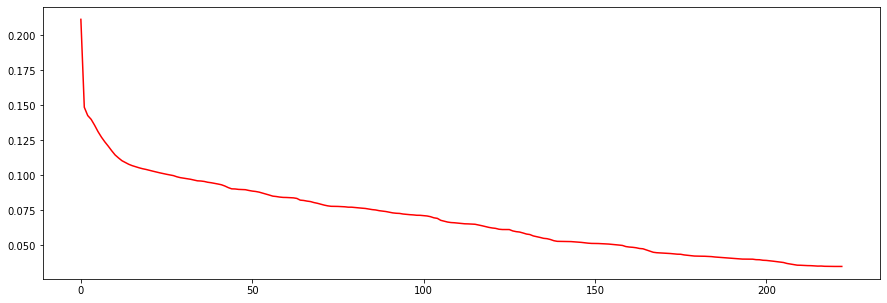

In [9]:
print(ai_history.history.keys())
plt.figure(figsize=(15,5))
plt.plot(ai_history.history['loss'], 'r')

## PREDICTION VERSION SETTING

In [10]:
## PREDICTION VERSION SETTING
start = datetime.now().replace(microsecond=0) + timedelta(hours=9)
pred_version = start.strftime("%Y%m%d_%H")
# pred_version = '20211102_13'

for timerange in range(500):
    if not os.path.exists(pwd+'/ot_model/'+pred_version):
        new_time = start - timedelta(hours=timerange+1)
        pred_version = new_time.strftime("%Y%m%d_%H")
    else:
        break

In [11]:
## Test data preprocessing
test_x = scale_module(test_x, mode = 'trans')

In [12]:
model = load_model('{}/ot_model/{}.h5'.format(pwd, model_name))

In [13]:
pred = model.predict(test_x.values)

# Using RMSE
rmse = np.mean(np.power(test_x - pred, 2), axis=1)

temp = pd.DataFrame()
temp['rmse'] = rmse.values
temp['true'] = test_y.values
temp['threshold'] = temp['rmse'].rolling(10).mean()
temp['pred'] = np.where(temp['rmse']>temp['threshold']*1.5,1,0)

print("ACCURACY_SCORE : {}".format(accuracy_score(temp['true'], temp['pred'])))

from sklearn.metrics import confusion_matrix
confusion_matrix(temp['true'], temp['pred'])

ACCURACY_SCORE : 0.9517304189435337


array([[2066,   24],
       [  82,   24]])

## Result insert to DB

In [14]:
test_x['ai_label_true'] = temp['true'].values
test_x['ai_label_pred'] = temp['pred'].values
test_x['rmse'] = temp['rmse'].values

label_df = test_x[['ai_label_true', 'ai_label_pred', 'rmse']].reset_index(drop = False)
label_df.rename(columns = {'time':'logtime'}, inplace = True)

insert_df = pd.DataFrame(columns = ['logtime','tag_name','tag_value'], data = test_x.stack().reset_index().values)
insert_df = pd.merge(insert_df, label_df, on = ['logtime'])
insert_df['version'] = pred_version

insert_df['logtime'] = pd.to_datetime(insert_df['logtime'])
insert_df['tag_value'] = insert_df['tag_value'].astype('float')
insert_df['ai_label_true'] = np.where(insert_df['ai_label_true'] == 1, 'NORMAL', 'ANOMALY')
insert_df['ai_label_pred'] = np.where(insert_df['ai_label_pred'] == 1, 'NORMAL', 'ANOMALY')

In [15]:
# execute_ch("INSERT INTO dti.kisa_ot_anomaly_detection_result VALUES", insert_df.to_dict('records'))